**Using a pretrained *densenet121* with some fully connected layers I trained a model to classify given training images(dataset1) with metadata (variety and age) into 100 different classes in this notebook**

Import all necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from torch.amp import autocast, GradScaler
import time
import copy
import glob

Check for CUDA

In [2]:
print(f'torch version = {torch.__version__}')
#checking if CUDA is available
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

torch version = 2.5.0+cu118
device = cuda


Set seed for reproducability

In [3]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define some hyperparameters

In [4]:
IMG_SIZE = 224  #Since densenet121 is trained on 224x224 images
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10  # 9 diseases + normal
LEARNING_RATE = 0.001

Defining dataset path and transformations

In [5]:
# Paths - update these to match your dataset location
DATASET_PATH = '.'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train_images')

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Defined function to compute mean metadata

Defined a class to preparae dataset by attaching image to metadata 

In [6]:
# Create dataset classes with metadata handling
class PaddyLeafDatasetWithMetadata(Dataset):
    def __init__(self, root_dir, metadata_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load metadata
        self.metadata = pd.read_csv(metadata_file)

        # Get all image paths and labels
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_path in glob.glob(os.path.join(class_dir, '*.jpg')):
                self.samples.append((img_path, self.class_to_idx[class_name]))

        # Create a dictionary to quickly lookup metadata for each image
        self.img_name_to_metadata = {}
        for _, row in self.metadata.iterrows():
            self.img_name_to_metadata[row['image_id']] = {
                'variety': row['variety'],
                'age': row['age']
            }

        # Get unique variety and age values for one-hot encoding
        self.varieties = sorted(self.metadata['variety'].unique())
        self.variety_to_idx = {variety: i for i, variety in enumerate(self.varieties)}

        # For age, we'll treat it as a normalized numerical value


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract image name from path
        img_name = os.path.basename(img_path)

        # Get metadata for this image
        metadata = self.img_name_to_metadata.get(img_name, {'variety': self.varieties[0], 'age': 0})

        # One-hot encode variety
        variety_idx = self.variety_to_idx.get(metadata['variety'], 0)
        variety_one_hot = torch.zeros(len(self.varieties))
        variety_one_hot[variety_idx] = 1.0

        # Normalize age (assuming age is a number, if it's categorical, you'd one-hot encode it too)
        try:
            age = float(metadata['age']) / 82.0  # Normalizing assuming max age is 100
        except (ValueError, TypeError):
            age = 0.0  # Default age if not available or not a number
        self.age = age

        return image, label, variety_one_hot, torch.tensor([age], dtype=torch.float32)

Defined a function to return a susbset of given dataset (used for train-val split)

In [7]:
# Create subset datasets
class SubsetDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

Created my dataset with metadata

In [8]:
train_dataset = PaddyLeafDatasetWithMetadata(TRAIN_PATH, 'train.csv', transform=train_transforms)
print(len(train_dataset))

10417


Prepared train and validation loader

In [9]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Custom random split
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]


train_subset = SubsetDataset(train_dataset, train_indices)
val_subset = SubsetDataset(train_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
class_names = train_dataset.classes

In [10]:
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

Some information about training and validation set

In [11]:
print(f"Classes: {class_names} \n")
print(f"Varieties: {train_dataset.varieties} \n")
print(f"Number of training samples: {len(train_subset)} \n")
print(f"Number of validation samples: {len(val_subset)}")

Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'] 

Varieties: ['ADT45', 'AndraPonni', 'AtchayaPonni', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'RR', 'Surya', 'Zonal'] 

Number of training samples: 8333 

Number of validation samples: 2084


Defined my model, used a pre=trained **densenet121** for image's feature extraction and then passed it through FCNN along with metadata

In [12]:
# Modified CNN model that incorporates metadata
class MetadataAwareModel(nn.Module):
    def __init__(self, base_model_name='resnet50', num_classes=10, num_varieties=1):
        super(MetadataAwareModel, self).__init__()

        # Initialize the CNN backbone
        if base_model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            self.feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Remove the final fully connected layer

        elif base_model_name == 'efficientnet':
            self.backbone = models.efficientnet_b0(pretrained=True)
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()  # Remove the final classifier

        elif base_model_name == 'densenet':
            self.backbone = models.densenet121(pretrained=True)
            self.feature_dim = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()  # Remove the final classifier

        # Layers for processing metadata
        self.variety_fc = nn.Linear(num_varieties, 64)
        self.age_fc = nn.Linear(1, 16)

        # Combined feature dimension
        combined_dim = self.feature_dim + 64 + 16

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, variety, age):
        # Process image through the backbone
        image_features = self.backbone(image)

        # Process metadata
        variety_features = torch.relu(self.variety_fc(variety))
        age_features = torch.relu(self.age_fc(age))

        # Concatenate all features
        combined_features = torch.cat([image_features, variety_features, age_features], dim=1)

        # Final classification
        output = self.classifier(combined_features)

        return output

Defined a training function

In [13]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scaler = GradScaler()  # Enable AMP (Mixed Precision Training)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(f'In phase {phase}')
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            print(f'Starting iteration over data')
            for inputs, labels, varieties, ages in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                varieties = varieties.to(device)
                ages = ages.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                  with autocast(device_type=str(device)):  # Mixed Precision Training
                    outputs = model(inputs, varieties, ages)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                        # loss.backward()
                        # optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Defined a function to evaluate model

In [14]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, varieties, ages in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            varieties = varieties.to(device)
            ages = ages.to(device)

            outputs = model(inputs, varieties, ages)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    labels = list(range(len(train_dataset.classes)))
    report = classification_report(all_labels, all_preds,labels=labels, target_names=train_dataset.classes, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=labels)

    return report, conf_matrix, all_preds, all_labels

Defined a function for plotting

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('CNN_training_history_with_metadata.png')
    plt.show()


Defined a function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('CNN_confusion_matrix_with_metadata.png')
    plt.show()

Trained my model

In [17]:
model_name = 'densenet'  # Choose from: 'resnet50', 'efficientnet', 'densenet'
model = MetadataAwareModel(
    base_model_name=model_name,
    num_classes=len(train_dataset.classes),
    num_varieties=len(train_dataset.varieties)
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)

# Save the model
torch.save(model.state_dict(), f'paddy_disease_{model_name}_with_metadata.pth')

/home/dslab/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dslab/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
In phase train
Starting iteration over data
train Loss: 1.6842 Acc: 0.4163
In phase val
Starting iteration over data
val Loss: 1.5459 Acc: 0.4587

Epoch 2/10
----------
In phase train
Starting iteration over data
train Loss: 1.2774 Acc: 0.5668
In phase val
Starting iteration over data
val Loss: 1.2509 Acc: 0.5979

Epoch 3/10
----------
In phase train
Starting iteration over data
train Loss: 1.0547 Acc: 0.6547
In phase val
Starting iteration over data
val Loss: 1.0718 Acc: 0.6324

Epoch 4/10
----------
In phase train
Starting iteration over data
train Loss: 0.7895 Acc: 0.7377
In phase val
Starting iteration over data
val Loss: 0.6805 Acc: 0.7759

Epoch 5/10
----------
In phase train
Starting iteration over data
train Loss: 0.6521 Acc: 0.7877
In phase val
Starting iteration over data
val Loss: 0.5857 Acc: 0.8100

Epoch 6/10
----------
In phase train
Starting iteration over data
train Loss: 0.6126 Acc: 0.8002
In phase val
Starting iteration over data
val Loss: 0.5560

Evaluation report on validation set


Test Results:
Accuracy: 0.8421

Classification Report:
bacterial_leaf_blight: Precision: 0.7105, Recall: 0.3140, F1-Score: 0.4355
bacterial_leaf_streak: Precision: 0.8375, Recall: 0.8375, F1-Score: 0.8375
bacterial_panicle_blight: Precision: 0.8906, Recall: 0.8028, F1-Score: 0.8444
blast: Precision: 0.8159, Recall: 0.8839, F1-Score: 0.8486
brown_spot: Precision: 0.7035, Recall: 0.7143, F1-Score: 0.7089
dead_heart: Precision: 0.9377, Recall: 0.9679, F1-Score: 0.9525
downy_mildew: Precision: 0.7130, Recall: 0.6777, F1-Score: 0.6949
hispa: Precision: 0.8515, Recall: 0.8863, F1-Score: 0.8686
normal: Precision: 0.8980, Recall: 0.9296, F1-Score: 0.9135
tungro: Precision: 0.8578, Recall: 0.8391, F1-Score: 0.8484


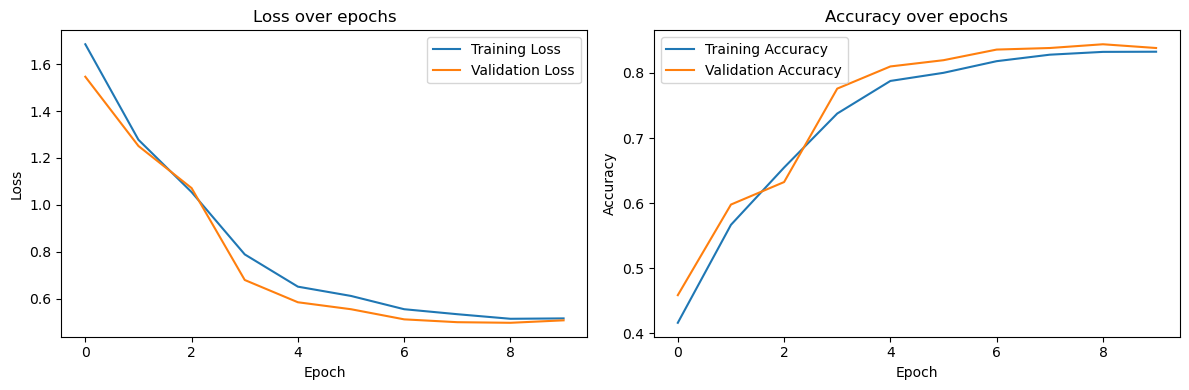

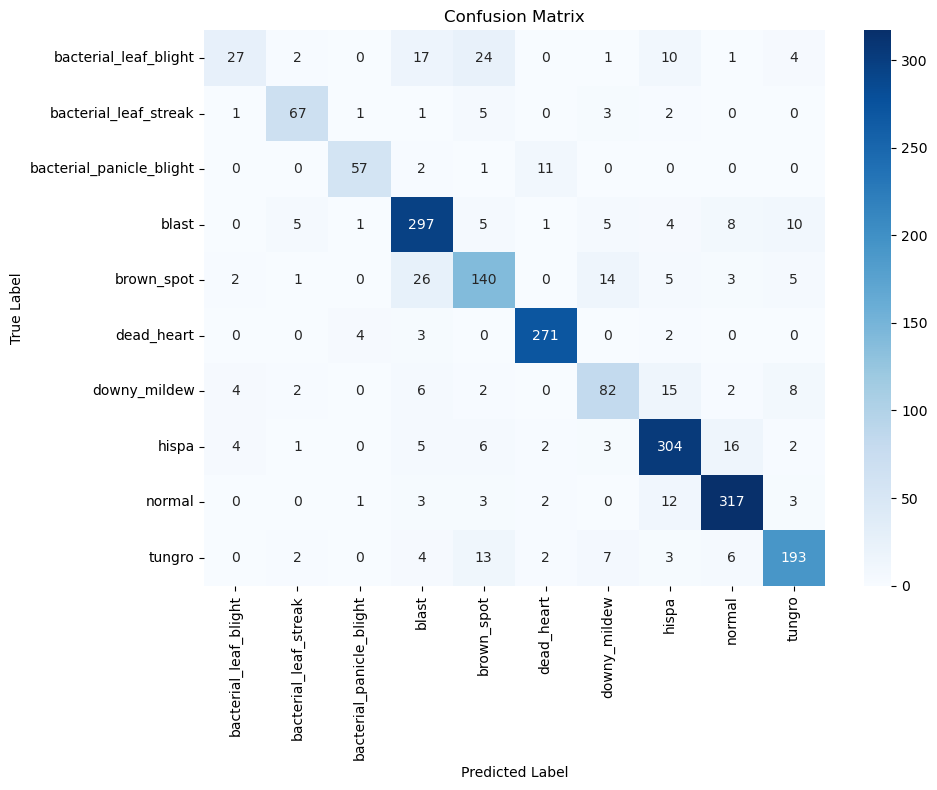

In [18]:
test_report, test_conf_matrix, test_preds, test_labels = evaluate_model(model, val_loader)

# Print test results
print("\nTest Results:")
print(f"Accuracy: {test_report['accuracy']:.4f}")
print("\nClassification Report:")
for class_name in train_dataset.classes:
    print(f"{class_name}: Precision: {test_report[class_name]['precision']:.4f}, "
            f"Recall: {test_report[class_name]['recall']:.4f}, "
            f"F1-Score: {test_report[class_name]['f1-score']:.4f}")

# Plot results
plot_training_history(history)
plot_confusion_matrix(test_conf_matrix, train_dataset.classes)